In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
from PIL import Image
import joblib

2025-10-29 14:32:10.771498: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 14:32:10.817723: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-29 14:32:11.026206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-29 14:32:11.026265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-29 14:32:11.068291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
data_dir = r"/home/faisal/code/MrZeroX1/Aivine/raw_data/Plant_type_classification/Plant_type_classification"


In [5]:
img_size = (128, 128)

In [6]:
# --- Image Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

In [7]:
# --- Load Images + Augmentation ---
X_aug, y_aug = [], []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg','.jpeg','.png','.webp')):
            img_path = os.path.join(folder_path, file)
            try:
                try:
                    img = load_img(img_path, target_size=img_size)
                except:
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                x = img_to_array(img)
                x = preprocess_input(x)  # MobileNetV2 preprocessing
                x = x.reshape((1, *x.shape))

                # Original image
                X_aug.append(x.flatten())
                y_aug.append(folder)

                # Generate 5 augmented images per original
                for i, batch in enumerate(datagen.flow(x, batch_size=1)):
                    X_aug.append(batch.flatten())
                    y_aug.append(folder)
                    if i >= 4:  # 5 augmentations
                        break
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

X_aug = np.array(X_aug, dtype='float32')
y_aug = np.array(y_aug)

print(f" Total images after augmentation: {len(X_aug)}")


/home/faisal/.pyenv/versions/3.10.14/envs/aivine_env/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 Total images after augmentation: 2370


In [8]:
# --- Encode Labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y_aug)

# --- Split Dataset ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_aug, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- MobileNetV2 Feature Extractor ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')
def extract_features(X):
    X_reshaped = X.reshape((-1, *img_size, 3))
    return base_model.predict(X_reshaped, verbose=0)

X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)


In [19]:
# --- Encode Labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y_aug)

# --- Split Dataset ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_aug, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- MobileNetV2 Feature Extractor ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')
def extract_features(X):
    X_reshaped = X.reshape((-1, *img_size, 3))
    return base_model.predict(X_reshaped, verbose=0)

X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)


# --- Models and Hyperparameters ---
models_params = {
    "SVM": (
        SVC(),
        {'C':[1,5,10], 'gamma':[0.001,0.01,'scale'], 'kernel':['rbf']}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {'n_estimators':[100,200], 'max_depth':[10,15,None]}
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=2000),
        {'C':[0.1,1,10]}
    )
}

# --- Train & GridSearch ---
best_results = []
for name, (model, params) in models_params.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_features, y_train)
    best_model = grid.best_estimator_
    print(f"Best Params: {grid.best_params_}")

    y_pred = best_model.predict(X_val_features)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_val, y_pred, target_names=le.classes_))

    best_results.append((name, acc, best_model))


Training SVM...
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 97.89%
               precision    recall  f1-score   support

Chrysanthemum       0.99      0.98      0.98        82
     Hibiscus       0.98      0.93      0.95        89
  Money_Plant       1.00      1.00      1.00        95
         Rose       0.95      0.98      0.97       116
     Turmeric       0.99      1.00      0.99        92

     accuracy                           0.98       474
    macro avg       0.98      0.98      0.98       474
 weighted avg       0.98      0.98      0.98       474


Training RandomForest...
Best Params: {'max_depth': 15, 'n_estimators': 200}
RandomForest Accuracy: 88.61%
               precision    recall  f1-score   support

Chrysanthemum       0.95      0.88      0.91        82
     Hibiscus       0.94      0.73      0.82        89
  Money_Plant       0.94      0.89      0.92        95
         Rose       0.76      0.93      0.84       116
     Turmeric       0.

In [20]:
# --- Summary ---
best_overall = max(best_results, key=lambda x: x[1])
print(f"\nBest Model: {best_overall[0]} | Accuracy: {best_overall[1]*100:.2f}%")


Best Model: SVM | Accuracy: 97.89%


In [21]:
for name, acc, model in best_results:
    print(f"Model Name: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Model Object: {model}")
    print('-'*40)

Model Name: SVM
Accuracy: 0.9789
Model Object: SVC(C=10)
----------------------------------------
Model Name: RandomForest
Accuracy: 0.8861
Model Object: RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)
----------------------------------------
Model Name: LogisticRegression
Accuracy: 0.9494
Model Object: LogisticRegression(C=1, max_iter=2000)
----------------------------------------


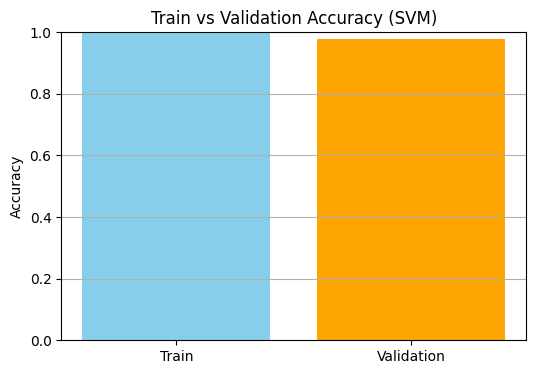

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model = best_overall[2]

y_train_pred = model.predict(X_train_features)
train_accuracy = accuracy_score(y_train, y_train_pred)

val_accuracy = best_overall[1]

plt.figure(figsize=(6,4))
plt.bar(['Train', 'Validation'], [train_accuracy, val_accuracy], color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy (SVM)')
plt.grid(axis='y')
plt.show()


In [8]:
import joblib
import pickle
import h5py
import numpy as np

model = joblib.load("best_model_svm.pkl")

model_bytes = pickle.dumps(model)

with h5py.File('best_model_svm.h5', 'w') as f:
    f.create_dataset('svm_model', data=np.void(model_bytes))

print("SVM model converted to H5 successfully")


SVM model converted to H5 successfully


In [18]:
joblib.dump(le, "label_encoder.pkl")
print("LabelEncoder saved as label_encoder.pkl")

LabelEncoder saved as label_encoder.pkl


In [ ]:
# loaded_model = joblib.load("best_model_svm.pkl")
# predictions = loaded_model.predict(X_new_features)

In [ ]:
"""
best_model = joblib.load("best_model_svm.pkl")
le = joblib.load("label_encoder.pkl")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')

def predict_plant(img_path):
    img = load_img(img_path, target_size=(128,128))
    x = img_to_array(img)
    x = preprocess_input(x)
    x = x.reshape((1, 128, 128, 3))
    features = base_model.predict(x, verbose=0)
    pred_idx = best_model.predict(features)[0]
    pred_class = le.inverse_transform([pred_idx])[0]
    return pred_class

print("Predicted class:", predict_plant("test_image/test7.png"))

"""


Predicted class: Hibiscus


In [ ]:
"""

from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
import joblib

best_model = joblib.load("best_model_svm.pkl")
le = joblib.load("label_encoder.pkl")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3), pooling='avg')

def predict_plant_from_bytes(img_bytes):

    img = Image.open(img_bytes).convert("RGB").resize((128,128))

    x = img_to_array(img)
    x = preprocess_input(x)
    x = x.reshape((1, *x.shape))

    features = base_model.predict(x, verbose=0)

    pred_idx = best_model.predict(features)[0]
    pred_class = le.inverse_transform([pred_idx])[0]
    return pred_class



"""

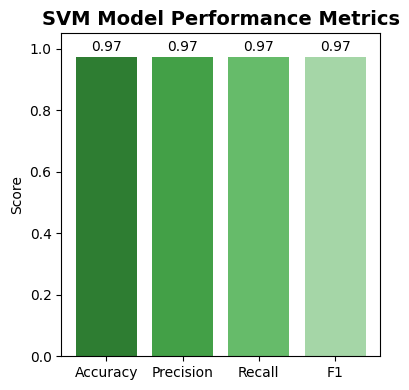

In [18]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# تحميل المودل
model = joblib.load("best_model_svm.pkl")

# التنبؤ
y_pred = model.predict(X_val_features)

# استخراج المقاييس
report = classification_report(y_val, y_pred, output_dict=True)

accuracy = accuracy_score(y_val, y_pred)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1 = report['macro avg']['f1-score']

# إنشاء DataFrame للعرض
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
values = [accuracy, precision, recall, f1]
df = pd.DataFrame({'Metric': metrics, 'Score': values})

# رسم النتائج
plt.figure(figsize=(4,4))
bars = plt.bar(df['Metric'], df['Score'], color=['#2E7D32', '#43A047', '#66BB6A', '#A5D6A7'])

# إضافة القيم على الأعمدة
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.01, f'{value:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.05)
plt.title('SVM Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.tight_layout()

# حفظ الصورة (اختياري)
plt.savefig("svm_model_metrics.png", dpi=300)
plt.show()


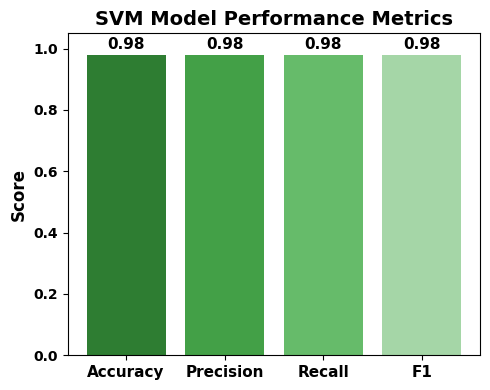

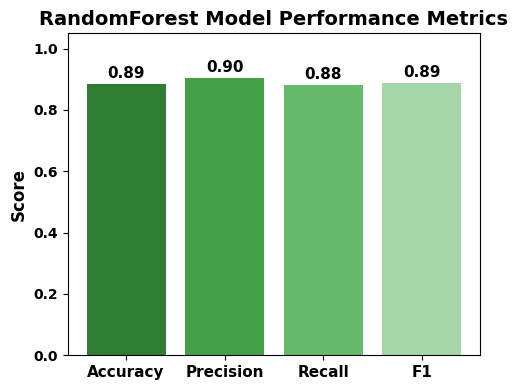

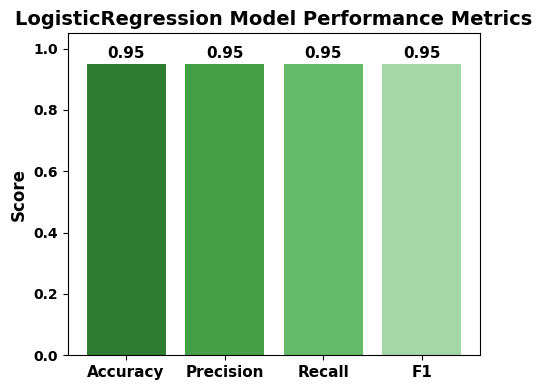

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# إنشاء رسم بياني لكل مودل داخل best_results
for name, acc, model in best_results:
    # التنبؤ بالقيم
    y_pred = model.predict(X_val_features)

    # استخراج المقاييس
    report = classification_report(y_val, y_pred, output_dict=True)

    accuracy = accuracy_score(y_val, y_pred)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    # إنشاء DataFrame بسيط للعرض
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
    values = [accuracy, precision, recall, f1]
    df = pd.DataFrame({'Metric': metrics, 'Score': values})

    # رسم النتائج
    plt.figure(figsize=(5,4))
    bars = plt.bar(df['Metric'], df['Score'],
                   color=['#2E7D32', '#43A047', '#66BB6A', '#A5D6A7'])

    # عرض القيم على الأعمدة بخط بولد
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, value + 0.01,
                 f'{value:.2f}', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

    # إعدادات النصوص والعناوين بخط بولد
    plt.ylim(0, 1.05)
    plt.title(f'{name} Model Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.xticks(fontsize=11, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')

    plt.tight_layout()


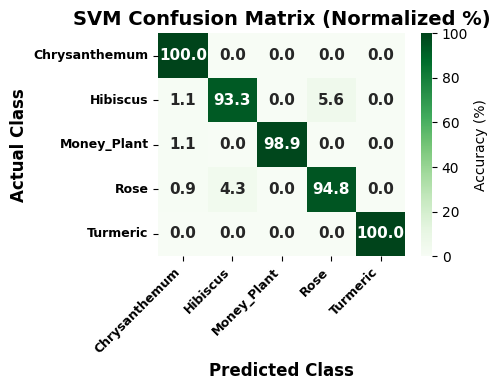

In [28]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# تحميل المودل
model = joblib.load("best_model_svm.pkl")

# التنبؤ
y_pred = model.predict(X_val_features)

# إنشاء مصفوفة الالتباس
cm = confusion_matrix(y_val, y_pred)

# تحويلها إلى نسب مئوية
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# الكلاسات
class_names = le.classes_

# إعداد الشكل بدون خلفية
plt.figure(figsize=(5, 4), facecolor='none')

# رسم المصفوفة
sns.heatmap(cm_percent,
            annot=True,
            fmt=".1f",
            cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Accuracy (%)'},
            annot_kws={"size":11, "fontweight":'bold'})

plt.title("SVM Confusion Matrix (Normalized %)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Class", fontsize=12, fontweight='bold')
plt.ylabel("Actual Class", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9, fontweight='bold')
plt.yticks(rotation=0, fontsize=9, fontweight='bold')

# إزالة الخلفية
plt.gca().set_facecolor('none')

plt.tight_layout()

# حفظ الصورة بخلفية شفافة
plt.savefig("svm_confusion_matrix_transparent.png", dpi=300, transparent=True)
plt.show()
